In [1]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
import itertools
import string
import enchant

from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import normalize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier
from sklearn import metrics
from matplotlib import pyplot as plt

In [2]:
def load_data(fname):
    """
    Reads in a csv file and return a dataframe. A dataframe df is similar to dictionary.
    You can access the label by calling df['label'], the content by df['content']
    the rating by df['rating']
    """
    return pd.read_csv(fname)

In [3]:
def extract_dictionary(df):
    """
    Reads a panda dataframe, and returns a dictionary of distinct words
    mapping from each distinct word to its index (ordered by when it was found).
    Input:
        df: dataframe/output of load_data()
    Returns:
        a dictionary of distinct words that maps each distinct word
        to a unique index corresponding to when it was first found while
        iterating over all words in each review in the dataframe df
    """
    word_dict = {}
    # TODO: Implement this function
    set_d = set()
    for i in range(df.index.size):
        str = df.loc[i]["text"].lower()
        for c in string.punctuation:
            str = str.replace(c, ' ')
        set_d = set_d.union(set(str.split()))

        
    # ignore the unnecessary words
    ignore = ['a', 'the', 'i', 'is', 'are', 'an']
    set_d = [a for a in set_d if a not in ignore]
    for i in range(len(set_d)):
        word_dict[set_d[i]] = i
    return word_dict

In [4]:
def generate_feature_matrix(df, word_dict, time_zone):
    """
    Reads a dataframe and the dictionary of unique words
    to generate a matrix of {1, 0} feature vectors for each review.
    Use the word_dict to find the correct index to set to 1 for each place
    in the feature vector. The resulting feature matrix should be of
    dimension (number of reviews, number of words).
    Input:
        df: dataframe that has the ratings and labels
        word_list: dictionary of words mapping to indices
    Returns:
        a feature matrix of dimension (number of reviews, number of words)
    """
    number_of_reviews = df.shape[0]
    number_of_words = len(word_dict)
    number_of_timezones = len(time_zone)
    feature_matrix = np.zeros((number_of_reviews, number_of_words + number_of_timezones))
    # TODO: Implement this function
    for i in range(df.index.size):
        str = df.loc[i]["text"].lower()
        for c in string.punctuation:
            str = str.replace(c, ' ')
        for part in str.split():
            if part in word_dict: feature_matrix[i][word_dict.get(part)] += 1
        str = df.loc[i]["user_timezone"]
        if str in time_zone: feature_matrix[i][number_of_words + time_zone.get(str)] = 1
    feature_matrix = normalize(feature_matrix, norm = 'max')
    return feature_matrix

In [5]:
def get_multiclass_training_data():
    """
    Reads in the data from data/dataset.csv and returns it using
    extract_dictionary and generate_feature_matrix as a tuple
    (X_train, Y_train) where the labels are multiclass as follows
        -1: poor
         0: average
         1: good
    Also returns the dictionary used to create X_train.
    """
    fname = "data/dataset.csv"
    dataframe = load_data(fname)
    neutralDF = dataframe[dataframe['label'] == 0].copy()
    positiveDF = dataframe[dataframe['label'] == 1].copy()
    negativeDF = dataframe[dataframe['label'] == -1].copy()
#     n_x_train, n_x_test = train_test_split(neutralDF, test_size = 0.1)
#     p_x_train, p_x_test = train_test_split(positiveDF, test_size = 0.1)
#     g_x_train, g_x_test = train_test_split(negativeDF, test_size = 0.1)
#     X_train = pd.concat([n_x_train, p_x_train, g_x_train]).reset_index(drop=True).copy()
    X_train = pd.concat([neutralDF, positiveDF, negativeDF]).reset_index(drop=True).copy()
    dictionary = extract_dictionary(X_train)
    time_zone = extract_time_zone(X_train)
#     X_test = pd.concat([n_x_test, p_x_test, g_x_test]).reset_index(drop=True).copy()
    X_test = pd.concat([neutralDF, positiveDF, negativeDF]).reset_index(drop=True).copy()
    Y_train = X_train['label'].values.copy()
    Y_test = X_test['label'].values.copy()
    X_train = generate_feature_matrix(X_train, dictionary, time_zone)
    X_test = generate_feature_matrix(X_test, dictionary, time_zone)
    


    return (X_train, Y_train, X_test, Y_test, dictionary, time_zone)

In [6]:
def extract_time_zone(df):
    time_zone = {}
    # TODO: Implement this function
    set_t = set()
    for i in range(df.index.size):
        str = df.loc[i]["user_timezone"]
        set_t.add(str)
    set_t = list(set_t)
    for i in range(len(set_t)):
        time_zone[set_t[i]] = i
    return time_zone

In [7]:
def generate_challenge_labels(y, uniqname):
    """
    Takes in a numpy array that stores the prediction of your multiclass
    classifier and output the prediction to held_out_result.csv. Please make sure that
    you do not change the order of the ratings in the heldout dataset since we will
    this file to evaluate your classifier.
    """
    pd.Series(np.array(y)).to_csv(uniqname+'.csv', header=['label'], index=False)
    return

In [8]:
def get_heldout_reviews(dictionary, time_zone):
    """
    Reads in the data from data/heldout.csv and returns it as a feature
    matrix based on the functions extract_dictionary and generate_feature_matrix
    Input:
        dictionary: the dictionary created by get_multiclass_training_data
    """
    fname = "data/heldout.csv"
    dataframe = load_data(fname)
    X = generate_feature_matrix(dataframe, dictionary, time_zone)
    return X

In [9]:
def select_classifier(penalty='l2', c=1.0, degree=1, r=0.0, class_weight='balanced'):
    """
    Return a linear svm classifier based on the given
    penalty function and regularization parameter c.
    """

    if penalty == 'l1': return LinearSVC(penalty = 'l1', dual = False, C = c, class_weight = class_weight, max_iter = 1000000, multi_class ='ovr')
    if degree == 1: return SVC(kernel='linear', C=c, class_weight=class_weight, degree = degree,decision_function_shape = 'ovr')
    if degree == 2: return SVC(gamma = 'auto', kernel='poly', C=c, class_weight=class_weight, degree = degree, coef0 = r, decision_function_shape = 'ovo')

In [10]:
def cv_performance(clf, X, y, k=5, metric="accuracy"):
    """
    Splits the data X and the labels y into k-folds and runs k-fold
    cross-validation: for each fold i in 1...k, trains a classifier on
    all the data except the ith fold, and tests on the ith fold.
    Calculates the k-fold cross-validation performance metric for classifier
    clf by averaging the performance across folds.
    Input:
        clf: an instance of SVC()
        X: (n,d) array of feature vectors, where n is the number of examples
           and d is the number of features
        y: (n,) array of binary labels {1,-1}
        k: an int specifying the number of folds (default=5)
        metric: string specifying the performance metric (default='accuracy'
             other options: 'f1-score', 'auroc', 'precision', 'sensitivity',
             and 'specificity')
    Returns:
        average 'test' performance across the k folds as np.float64
    """
    # TODO: Implement this function
    #HINT: You may find the StratifiedKFold from sklearn.model_selection
    #to be useful

    #Put the performance of the model on each fold in the scores array
    scores = []
    skf = StratifiedKFold(k)
    skf.get_n_splits(X, y)

    for train_ind, test_ind in skf.split(X, y):
        X_train = X[train_ind]
        y_train = y[train_ind]
        clf = clf.fit(X_train,y_train)
        X_test = X[test_ind]
        if metric == 'AUROC':
            y_pred = clf.decision_function(X_test)
        else:
            y_pred = clf.predict(X_test)
        y_true = y[test_ind]
        scores.append(performance(y_true, y_pred, metric))

    #And return the average performance across all fold splits.
    return np.array(scores).mean()


In [11]:
def select_param_linear(X, y, k=5, metric="accuracy", C_range = [], penalty='l2'):
    """
    Sweeps different settings for the hyperparameter of a linear-kernel SVM,
    calculating the k-fold CV performance for each setting on X, y.
    Input:
        X: (n,d) array of feature vectors, where n is the number of examples
        and d is the number of features
        y: (n,) array of binary labels {1,-1}
        k: int specifying the number of folds (default=5)
        metric: string specifying the performance metric (default='accuracy',
             other options: 'f1-score', 'auroc', 'precision', 'sensitivity',
             and 'specificity')
        C_range: an array with C values to be searched over
    Returns:
        The parameter value for a linear-kernel SVM that maximizes the
        average 5-fold CV performance.
    """
    # TODO: Implement this function
    #HINT: You should be using your cv_performance function here
    #to evaluate the performance of each SVM
    
    
    max, max_val = 0, 0
    for potential in C_range:
        clf = select_classifier(c = potential, penalty = penalty)
        cur = cv_performance(clf,X,y,k,metric)
        if cur > max_val:
            max = potential
            max_val = cur
    return max, max_val

In [12]:
def select_param_quadratic(X, y, k=5, metric="accuracy", param_range=[]):
    """
        Sweeps different settings for the hyperparameters of an quadratic-kernel SVM,
        calculating the k-fold CV performance for each setting on X, y.
        Input:
            X: (n,d) array of feature vectors, where n is the number of examples
               and d is the number of features
            y: (n,) array of binary labels {1,-1}
            k: an int specifying the number of folds (default=5)
            metric: string specifying the performance metric (default='accuracy'
                     other options: 'f1-score', 'auroc', 'precision', 'sensitivity',
                     and 'specificity')
            parameter_values: a (num_param, 2)-sized array containing the
                parameter values to search over. The first column should
                represent the values for C, and the second column should
                represent the values for r. Each row of this array thus
                represents a pair of parameters to be tried together.
        Returns:
            The parameter value(s) for a quadratic-kernel SVM that maximize
            the average 5-fold CV performance
    """
    # TODO: Implement this function
    # Hint: This will be very similar to select_param_linear, except
    # the type of SVM model you are using will be different...

    max_c,max_r, max_val = 0, 0, 0
    for potent_c, potent_r in param_range:
        clf = select_classifier(c = potent_c, r = potent_r, degree = 2)
        cur = cv_performance(clf,X,y,k,metric)
        print(potent_c, potent_r, cur)
        if cur > max_val:
            max_c = potent_c
            max_r = potent_r
            max_val = cur
    print(metric, ":", max_c, max_r, max_val)
    return [max_c, max_r]

In [13]:
def performance(y_true, y_pred, metric="accuracy"):
    """
    Calculates the performance metric as evaluated on the true labels
    y_true versus the predicted labels y_pred.
    Input:
        y_true: (n,) array containing known labels
        y_pred: (n,) array containing predicted scores
        metric: string specifying the performance metric (default='accuracy'
                 other options: 'f1-score', 'auroc', 'precision', 'sensitivity',
                 and 'specificity')
    Returns:
        the performance as an np.float64
    """
    # TODO: Implement this function
    # This is an optional but very useful function to implement.
    # See the sklearn.metrics documentation for pointers on how to implement
    # the requested metrics.
        # Accuracy = (FP + FN) / N
    if (metric == 'Accuracy'):
        return metrics.accuracy_score(y_true, y_pred)
    
    # Recall/Sensitivity = TP / (TP + FN)
    elif (metric == 'Sensitivity'):
        return metrics.recall_score(y_true, y_pred)
    
    # Precision = TP / (TP + FP)
    elif (metric == 'Precision'):
        return metrics.precision_score(y_true, y_pred)
    
    # F1-Score = 2 * Precision * Sensitivity / (Precision + Sensitivity)
    elif (metric == "F1-Score"):
        return metrics.f1_score(y_true, y_pred)
    
    # AUROC
    elif (metric == "AUROC"):
        return metrics.roc_auc_score(y_true, y_pred)

    #Specificity = TN / (TN + FP)
    elif (metric == "Specificity"):
        TN, FP, FN, TP = metrics.confusion_matrix(y_true, y_pred).ravel()
        return TN / (TN + FP)


In [14]:
X_train, Y_train, X_test, Y_test, dictionary, time_zone = get_multiclass_training_data()
print(X_train.shape)

(3000, 5765)


In [119]:
# model = LinearSVC(C = 0.4, penalty="l1", dual=False, max_iter = 100000, multi_class ='ovr').fit(X_train, Y_train)
# model = SelectFromModel(model, prefit=True, max_features = 2000)
# X_train_new = model.transform(X_train)
# X_test_new = model.transform(X_test)

# clf = SVC(kernel='linear', C=0.25 ,degree = 1,decision_function_shape = 'ovr')
# clf.fit(X_train_new, Y_train)
# Y_pred = clf.predict(X_test_new)
# print(performance(Y_test, Y_pred,'Accuracy'))

In [16]:
model = LinearSVC(C = 0.4, penalty="l1", dual=False, max_iter = 100000, multi_class ='ovr').fit(X_train, Y_train)
model = SelectFromModel(model, prefit=True, max_features = 2000)
X_train_new = model.transform(X_train)
X_test_new = model.transform(X_test)
print(X_train_new.shape)

clf = OneVsRestClassifier(SVC(kernel='linear', C=0.25 ,degree = 1))
clf.fit(X_train_new, Y_train)
# Y_pred = clf.predict(X_test_new)
# print(performance(Y_test, Y_pred,'Accuracy'))

(3000, 1053)


OneVsRestClassifier(estimator=SVC(C=0.25, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=1, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          n_jobs=None)

In [17]:
hw_x_train = get_heldout_reviews(dictionary, time_zone)
hw_x_train_new = model.transform(hw_x_train)
Y_pred = clf.predict(hw_x_train_new)
generate_challenge_labels(Y_pred, 'jamiean')

In [125]:
# c_range = [0.1 * x for x in range(1,10)]
# x_range = []
# for x in c_range:
#     model = LinearSVC(C = x, penalty="l1", dual=False, max_iter = 100000, multi_class ='ovr').fit(X_train, Y_train)
#     model = SelectFromModel(model, prefit=True, max_features = 2000)
#     X_train_new = model.transform(X_train)
#     X_test_new = model.transform(X_test)
#     clf = LinearSVC(C = 1, penalty="l1", dual=False, max_iter = 1000000, multi_class ='ovr')
#     x_range.append(cv_performance(clf, X_train_new, Y_train, 5, "Accuracy"))
# plt.plot(c_range,x_range,'-o')
# plt.show()

In [ ]:
# model = LinearSVC(C=i * 0.1, penalty="l1", dual=False, max_iter = 100000, multi_class ='ovr').fit(X_train, Y_train)
# print(X_train.shape)
# model = SelectFromModel(model, prefit=True, max_features = 2000)
# X_train_new = model.transform(X_train)


# select_param_linear(X_train_new,Y_train,5,"Accuracy",c_range, penalty = 'l1')
# X_test_new = model.transform(X_test)
# print(X_train_new.shape)
# print(X_test_new.shape)

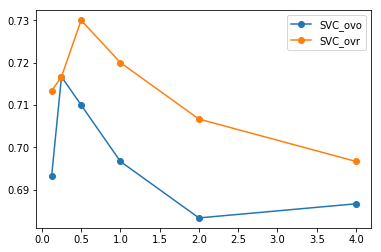

In [28]:
c_range = [2 ** x for x in range(-3,3)]
p_range = [0.1 * x for x in range(1,10)]
n = 0.25
ans = []
ans_1 = []
for x in c_range:
    clf = OneVsOneClassifier(SVC(kernel='linear', C=x,degree = 1))
    clf.fit(X_train_new, Y_train)
    Y_pred = clf.predict(X_test_new)
    ans.append(performance(Y_test, Y_pred,'Accuracy'))
    clf = OneVsRestClassifier(SVC(kernel='linear', C=x,degree = 1))
    clf.fit(X_train_new, Y_train)
    Y_pred = clf.predict(X_test_new)
    ans_1.append(performance(Y_test, Y_pred,'Accuracy'))
    
plt.plot(c_range,ans,'-o', label = 'SVC_ovo')
plt.plot(c_range,ans_1,'-o', label = 'SVC_ovr')
plt.legend()
plt.show()

In [126]:
# model = LinearSVC(C=0.4, penalty="l1", dual=False, max_iter = 100000, multi_class ='ovr')
# print(X_train.shape)
# selector = RFE(model, n_features_to_select = 600, step = 100)
# selector = selector.fit(X_train, Y_train)
# X_train_new = selector.transform(X_train)
# X_test_new = selector.transform(X_test)
# X_train = normalize(X_train, norm = 'max')
# X_test = normalize(X_test, norm = 'max')
# print(X_train_new.shape)

In [127]:
# X_train = normalize(X_train, norm = 'max')
# X_test = normalize(X_test, norm = 'max')

# for j in range(X_train.shape[1]):
#     std = np.std(X_train[:,j])
#     mean = np.mean(X_train[:,j])
#     for i in range(X_train.shape[0]):
#         X_train[i,j] = st.norm.cdf((X_train[i,j] - mean) / std)

In [ ]:
# param_range = [[40,4], [39,4], [41,4], [40,5], [40,3], [39, 5], [39, 3], [41,3]]
# # c = np.random.uniform(1,2,10)
# # r = np.random.uniform(1,2,10)
# # for i in range(10): param_range.append([10 ** c[i],10 ** r[i]])
# select_param_quadratic(X_train,Y_train,5,"Accuracy", param_range)

model = LinearSVC(C=0.5, penalty="l1", dual=False, max_iter = 100000, multi_class ='ovr').fit(X_train, Y_train)
print(X_train.shape)
model = SelectFromModel(model, prefit=True, max_features = 1600)
X_train_new = model.transform(X_train)
X_test_new = model.transform(X_test)

In [19]:
# After finding best parameter is among 0.1 ~ 1
# Run the regression selection
c_range = [ 10 ** x for x in range(-2,3)]
# c_range = [ 0.1 * x for x in range(1,10)]
select_param_linear(X_train_new,Y_train,5,"Accuracy",c_range, penalty = 'l1')

0.01 : 0.5383333333333333
0.1 : 0.6879166666666667
1 : 0.7233333333333334
10 : 0.6995833333333332
100 : 0.66875
Accuracy : 1 0.7233333333333334


1

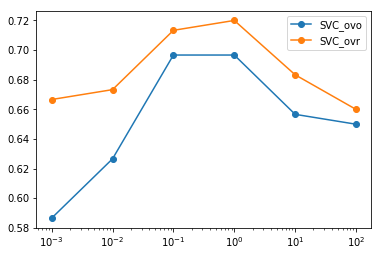

In [24]:
plt.plot(c_range,ans,'-o', label = 'SVC_ovo')
plt.plot(c_range,ans_1,'-o', label = 'SVC_ovr')
plt.legend()
plt.xscale('log')
plt.show()